In [3]:
import random
from random import shuffle 
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence

In [5]:
import collections
import io
import math
import os
import random
import pandas as pd
from six.moves import urllib

from IPython.display import clear_output, Image, display, HTML

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
import seaborn as sns

Instructions for updating:
non-resource variables are not supported in the long term


In [15]:
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('model/mobilenet/mobilenet_model.meta')
    #saver.restore(sess, tf.train.latest_checkpoint('./'))
    #print(sess.run('w1:0'))

In [10]:
def label_image_one_hot_encoder(img):
    label = img.split('_')[0]
    if label == 'cat': return 0
    elif label == 'dog': return 1
    
def process_data(image_list, DATA_FOLDER, IMG_SIZE):
    data_df = []
    for img in tqdm(image_list):
        path = os.path.join(DATA_FOLDER, img)
        label = label_image_one_hot_encoder(img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img - cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        data_df.append([np.array(img), np.array(label), path])
    shuffle(data_df)
    return data_df

def manual_pre_process(dir, IMG_SIZE):
    '''
    Creates an array of images, labels, and files from a directory of image files
    
    Args:
        dir: string, folder name
        IMG_SIZE: int, image height and width
    Returns:
        X: (n x IMG_SIZE x IMG_SIZE) numpy array of images
        y: (n,) numpy array of labels
        files: (n,) numpy array of files
    '''
    
    image_lst = os.listdir(dir)
    data_df = process_data(image_lst, dir, IMG_SIZE)
    X = np.array([i[0] for i in data_df]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    y = np.array([i[1] for i in data_df])
    files = np.array([i[2] for i in data_df])
    return X, y, files

In [11]:
val_imgs = 'dataset/val_1000'
class_info = {0: 'Cat', 1:'Dog'}

X, y, files = manual_pre_process(val_imgs, 224)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1078.28it/s]


## Loading Pre-Trained Model

In [15]:
import tensorflow as tf
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [16]:
model = tf.keras.models.load_model('model/mobilenetv2_epochs25_batch25_sample_size2000_aug_0.h5', custom_objects={"precision_m": precision, "recall_m": recall})

## Interpreting the Results with Grad-CAM

In [17]:
def decode_prediction(pred):
    # This function thresholds a probability to produce a prediction
    pred = tf.where(pred < 0.5, 0, 1)
    return pred.numpy()

Text(0.5, 1.0, 'Dog 0.98144543')

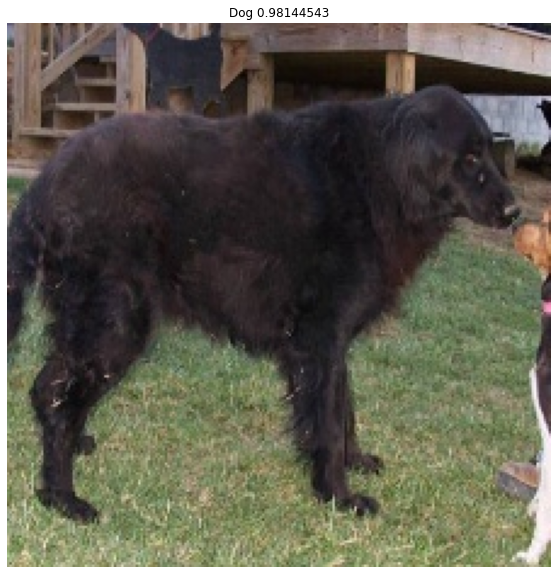

In [20]:
i = 178

img = X[i]
label = y[i]
path = files[i]

pred_raw = model.predict(np.expand_dims(img, axis=0))[0][0]
pred = decode_prediction(pred_raw)
pred_label = class_info[pred]

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(pred_label + ' ' + str(pred_raw))

In [26]:
from tensorflow.keras.models import Model

def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad=cam heatmap given a model and a layer name contained with that model
    
    Args:
        model: tf model
        img_array: (img_width x img_width) numpy array
        layer_name: str
        
    Returns
        uint8 numpy array with shape (img_height, img_weight)
    '''
    
    gradModel = Model(
        inputs = [model.inputs],
        outputs = [model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the image through the gradient model, and grab the loss associated with the specific class index
        inputs = tf.cast(img_array, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]
        
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    
    # the convolution and guided gradients have a batch dimension (which we don't need) so let's grab the volume itself and discard the batch
    convOutputs = convOutputs[0]
    guideGrads = guidedGrads[0]
    
    # compute the average of gradient values, and using them as weights, compute the ponderation of the filters with respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    
    # grab the spatial dimensions of the input image and resize the output class activation map to match the input image dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    
    # normalize the heatmap such that all values lie in the range [0, 1], scale teh resulting values to the range [0, 255], and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    
    # return the resulting heatmap 
    return heatmap

In [27]:
def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

In [30]:
def superimpose(img_bgr, cam, thresh, emphasize=False):
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization
    
    Args:
        image: (img_width x img_height x 3) numpy array
        grad-cam heatmap: (img_width x img_width) numpy array
        threshold: float
        emphasize: boolean
        
    Returns:
        uint8 numpy array with shape (img_height, img_width, 3)
    '''
    
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

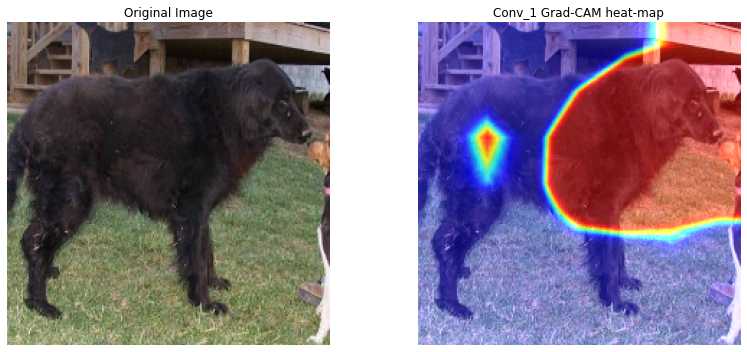

In [31]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1

layer_name = 'Conv_1'
grad_cam=GradCam(model, np.expand_dims(img, axis=0), layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()

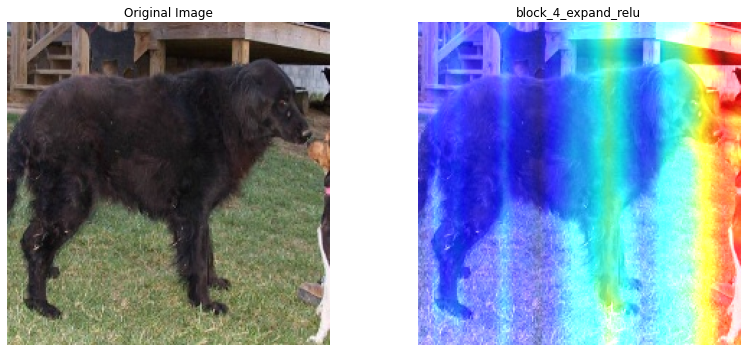

In [32]:
## Grad-CAM heatmap for the block_4_expand_relu
## This layer shows how the model begins learning concepts in the image

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
grad_cam = GradCam(model, np.expand_dims(img, axis=0), 'block_4_expand_relu')
grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
plt.imshow(grad_cam_emphasized)
plt.axis('off')
plt.title('block_4_expand_relu')
plt.tight_layout()


In [33]:
## Gather all convolution and activation layers from the model
## With these layers, we can explore grad-cam heatmaps for more layers in the model

conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and layer.__class__.__name__ == 'ReLU']
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv2D))]

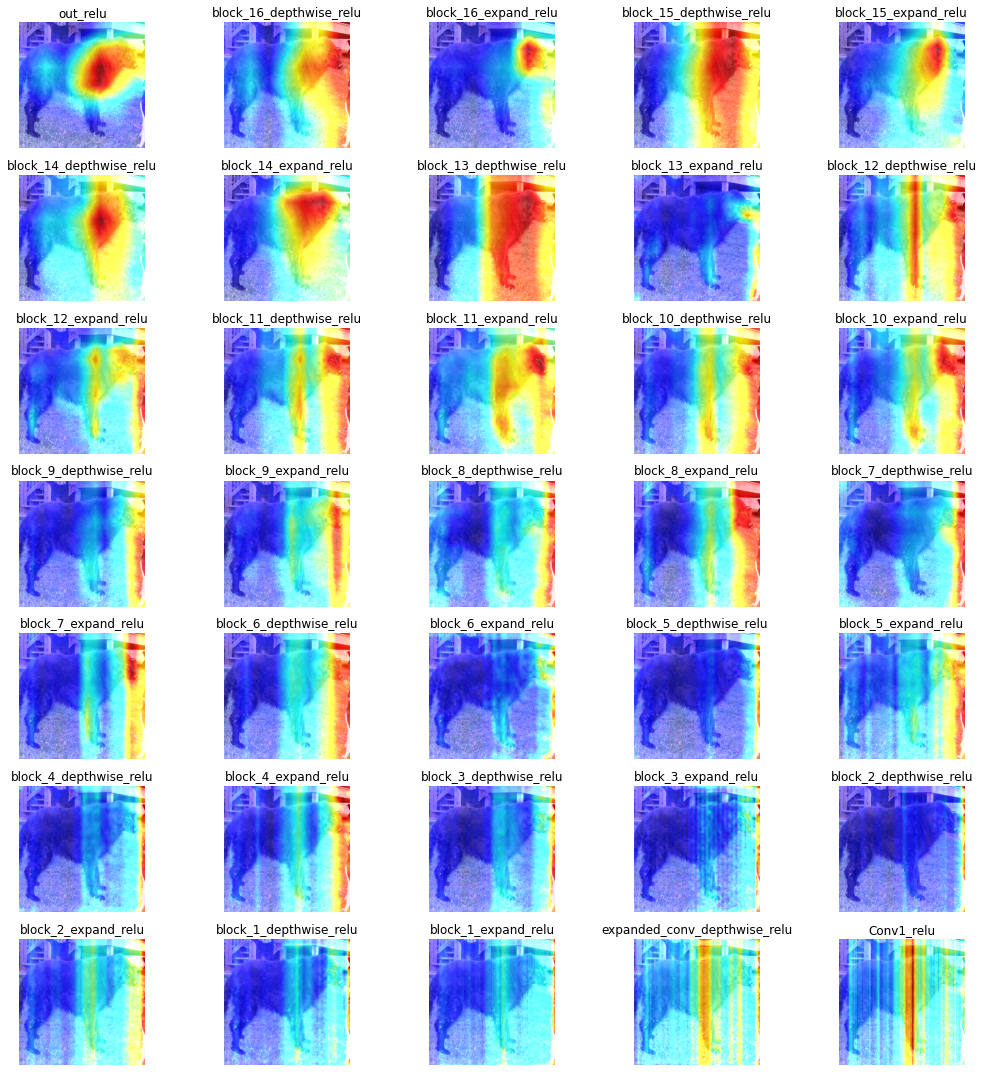

In [34]:
## Visualizing Activation layers
plt.figure(figsize=(15, 15))
for i, layer in enumerate(activation_layers):
  grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
  grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
  ax = plt.subplot(7, 5, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()


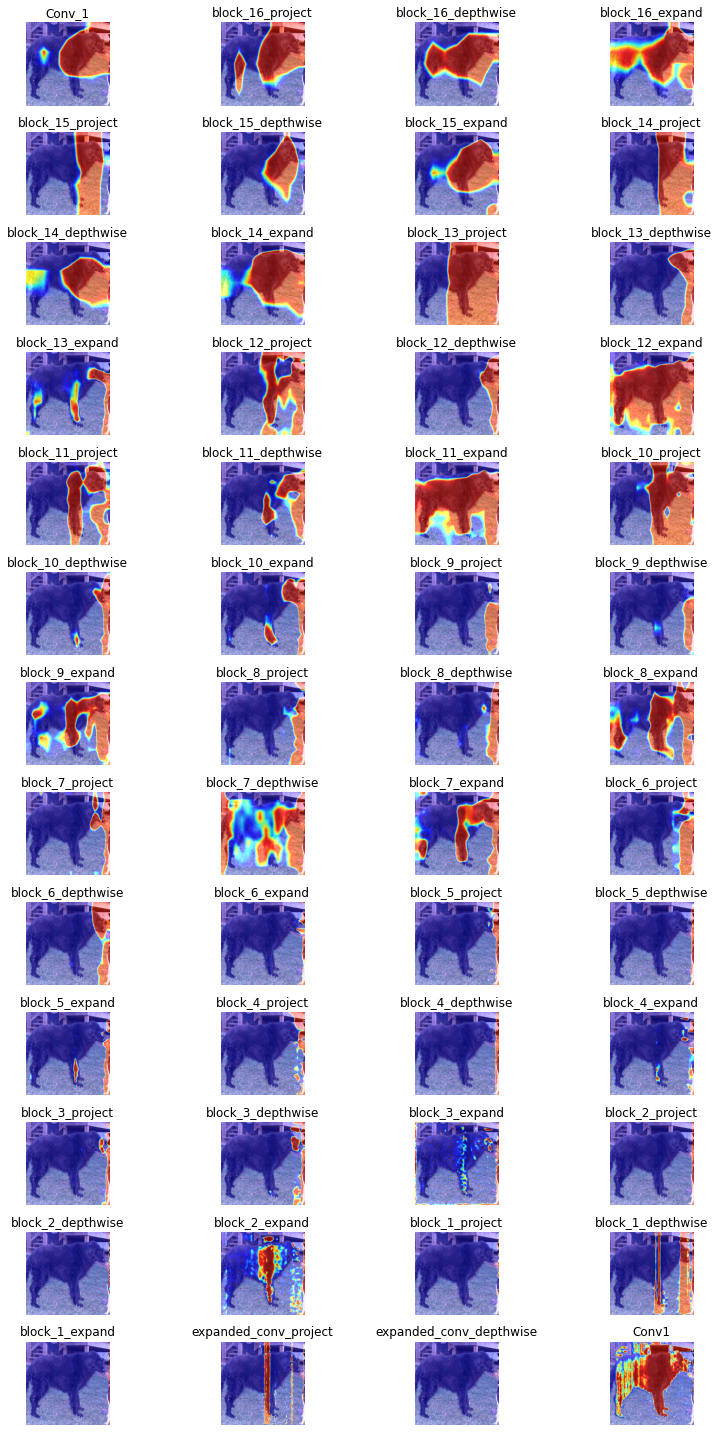

In [35]:
## Visualizing Convolution layers
plt.figure(figsize=(12, 20))
for i, layer in enumerate(conv2D_layers):
  grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
  grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=True)
  ax = plt.subplot(13, 4, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()


In [ ]:
def fuse_layers(layers, model, img, emphasize=False):
    '''
    Fuses grad-cam heatmaps from a list of model layers into a single heatmap and superimposes the heatmap onto an image
    
    Args:
        layers: list of strings
        model: tf model
        imgL (img_width x img_height x 3) numpy array
        
    Returns
        uint8 numpy array with shape (img_height, img_weight, 3)
    '''
    
    cams = []
    for layer in layers:
        cam = GradCam(model, np.expand_dims(img, axis=0), layer)
        cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
        cams.append(cam)
    
    fused = np.mean(cams, axis=0)
    superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)

    return superimposed